<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw6/Homework6_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

In [ ]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw6

In [ ]:
! pip install -r requirements.txt

In [ ]:
! git pull

In [6]:
%cd ../..

/Users/Egor.Spirin/HSE/HSE.Deep_Unsupervised_Learning


In [7]:
%%capture
! mkdir -p Homework/hw6/data
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O Homework/hw6/data/data.zip && rm -rf /tmp/cookies.txt
! unzip -qq Homework/hw6/data/data.zip -d Homework/hw6/data

In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from utils.hw6_utils import *
from vae.trainer import VAETrainer

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0

plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Question 1: VAEs on Images
In this question, you will train VAE model on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

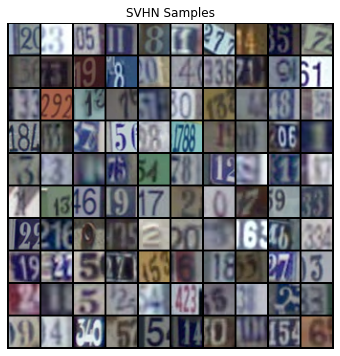

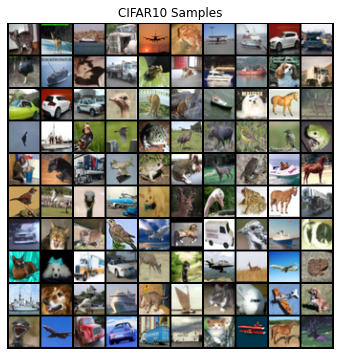

In [8]:
visualize_svhn()
visualize_cifar10()

## VAE with AF Prior
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as in homework 5. For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [17]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    train_data = 2 * (np.transpose(train_data, (0, 3, 1, 2)) / 255.0).astype('float32') - 1
    test_data = 2 * (np.transpose(test_data, (0, 3, 1, 2)) / 255.0).astype('float32') - 1

    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=256)

    vae_trainer = VAETrainer(in_channels=3, latent_dim=16, device=device, use_prior=True, made_hidden_dims=[32])

    train_losses, test_losses = vae_trainer.train(train_dataloader, n_epochs=1, lr=1e-3, test_dataloader=test_dataloader, beta=1.0)
    vae_model = vae_trainer.vae_model

    samples = (vae_trainer.sample(100).detach().cpu().numpy() * 0.5 + 0.5) * 255

    test_images = torch.tensor(test_data[:50], device=device)
    with torch.no_grad():
        test_reconstructed = torch.clip(vae_model(test_images)[0], -1, 1)
    pairs = (torch.vstack((test_images, test_reconstructed)).permute(0, 2, 3, 1).detach().cpu().numpy() * 0.5 + 0.5) * 255

    test_images = torch.tensor(test_data[50:70], device=device)
    with torch.no_grad():
        z = vae_model.reparameterize(*vae_model.encode(test_images))
        z1, z2 = z.chunk(2, dim=0)

        interpolations = torch.vstack([vae_model.decode(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)])
        interpolations = torch.clip(interpolations, -1, 1)
        interpolations = (interpolations.permute(0, 2, 3, 1).detach().cpu().numpy() * 0.5 + 0.5) * 255

    return train_losses, test_losses, samples, pairs, interpolations

### Results
Once you've finished `q1`, execute the cells below to visualize and save your results.

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Final -ELBO: 363.2108, Recon Loss: 354.8359, KL Loss: 8.3749


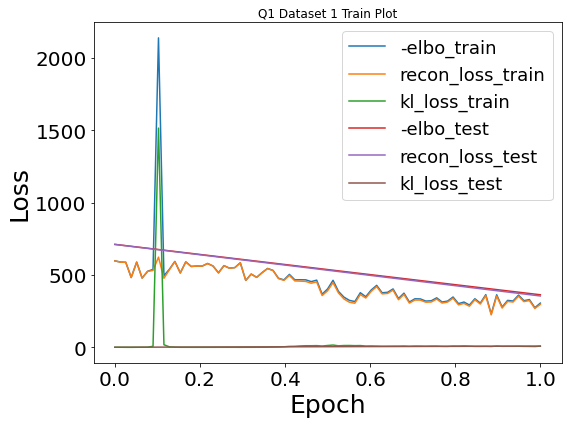

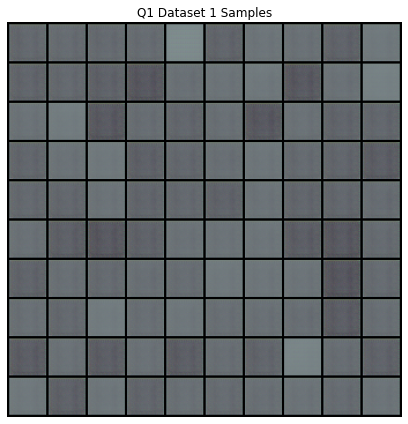

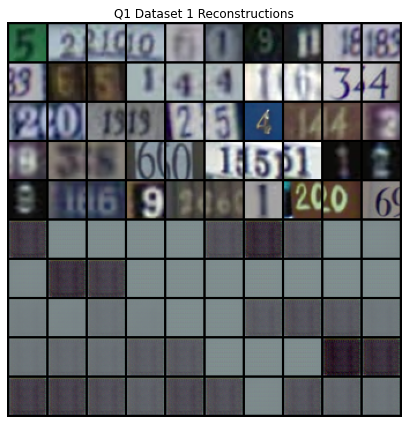

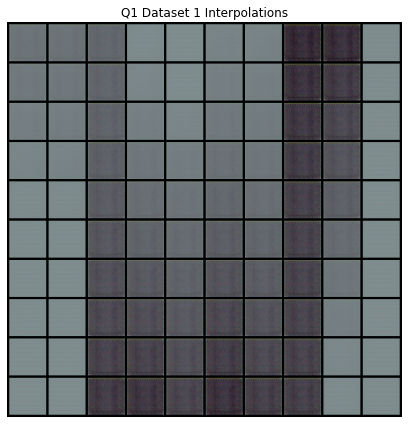

In [18]:
q1_save_results(1, q1)

In [ ]:
q1_save_results(2, q1)

# Question 2: VQ-VAE
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks (same structure as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q2(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

## Results
Once you've finished `q2`, execute the cells below to visualize and save your results.

VQ-VAE Final Test Loss: 0.0286
PixelCNN Prior Final Test Loss: 1.9440


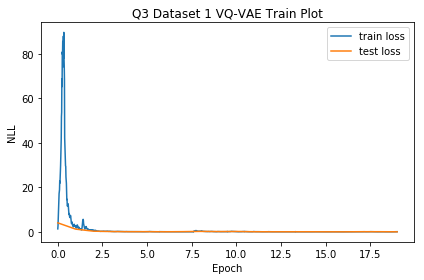

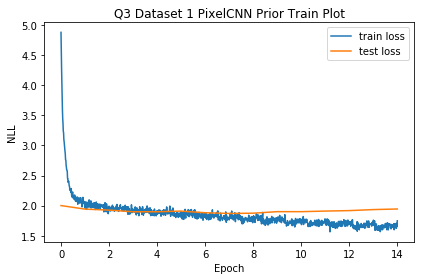

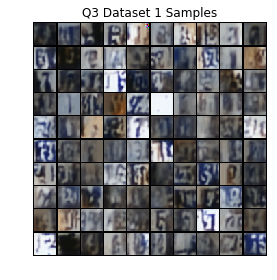

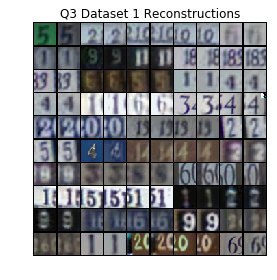

In [ ]:
q2_save_results(1, q2)

In [ ]:
q2_save_results(2, q2)

# Bonus 4

## Part (a) Improving VQ-VAE Results
Improve upon your results in Q2, one option being trying to implement or train a stronger autoregressive model such as a Gated PixelCNN.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def b4_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `b4_a`, execute the cells below to visualize and save your results.

In [ ]:
b4_a_save_results(2, b4_a)

## Part (b) PixelVAE
Implement and train a VAE with a PixelCNN decoder, and get it to produce good samples but not ignore latents. It may help to reference the latent variable model slides on techniques to prevent posterior collapse.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def b4_b(train_data, test_data):
    """
    train_data: An (n_train, 28, 28, 1) uint8 numpy array of MNIST binary images
    test_data: An (n_test, 28, 28, 1) uint8 numpy array of MNIST binary images

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 28, 28, 1) numpy array of 100 samples with values in {0, 1}
    - a (100, 28, 28, 1) numpy array of 50 real-image / reconstruction pairs with values in {0, 1}
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `b4_b`, execute the cells below to visualize and save your results

In [ ]:
b4_b_save_results(b4_b)